# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Cifar10

In [2]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 256
ds_train_cifar10 = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train_cifar10 = torch.utils.data.DataLoader(ds_train_cifar10, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test_cifar10 = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_test_cifar10 = torch.utils.data.DataLoader(ds_test_cifar10, batch_size=batch_size, shuffle=False, num_workers=2)

# Cifar10 classes
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Fake dataset

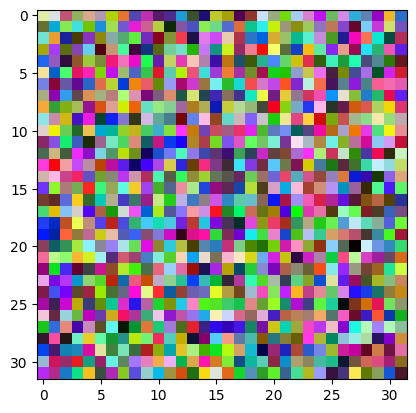

In [27]:
# Fake dataset.
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

# Plot a fake image.
plt.imshow(FakeData(size=1, image_size=(3, 32, 32))[0][0])

### Cifar100 subset

Files already downloaded and verified
['bowl', 'chair', 'dolphin', 'lamp', 'mouse', 'plain', 'squirrel', 'train', 'rose', 'bed']
5000
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


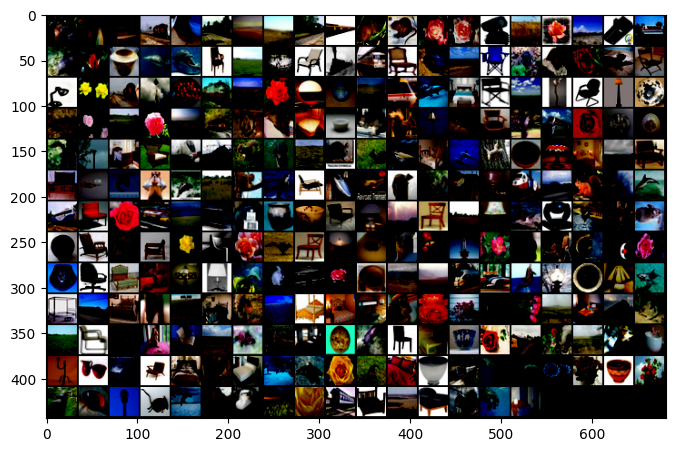

In [4]:
from typing import List
from torchvision.datasets import CIFAR100
import torchvision


class CIFAR100Subset(CIFAR100):
    def __init__(self, subset: List[int], **kwargs):
        super().__init__(**kwargs)
        self.subset = subset
        assert max(subset) <= max(self.targets)
        assert min(subset) >= min(self.targets)

        self.aligned_indices = []
        for idx, label in enumerate(self.targets):
            if label in subset:
                self.aligned_indices.append(idx)

    def get_class_names(self):
        return [self.classes[i] for i in self.subset]

    def __len__(self):
        return len(self.aligned_indices)

    def __getitem__(self, item):
        return super().__getitem__(self.aligned_indices[item])

transform = transforms.Compose(
[transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Get cifar100 subset
cifar100_subset_train = CIFAR100Subset(
    subset=[10, 20, 30, 40, 50, 60, 80, 90, 70, 5],
    root='./dataset',
    train=True,
    download=True,
    transform=transform
)

print(cifar100_subset_train.get_class_names())
print(len(cifar100_subset_train))

dl_train100 = torch.utils.data.DataLoader(cifar100_subset_train, batch_size=batch_size, shuffle=True, num_workers=2)
x, _ = next(iter(dl_train100))

cifar100_subset_test= CIFAR100Subset(
    subset=[10, 20, 30, 40, 50, 60, 80, 90, 70, 5],
    root='./dataset',
    train=False,
    download=True,
    transform=transform
)
dl_test100 = torch.utils.data.DataLoader(cifar100_subset_test, batch_size=batch_size, shuffle=False, num_workers=2)

grid_img = torchvision.utils.make_grid(x, nrow=20)
plt.figure(figsize=(8,8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

### CNN

In [5]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
model.load_state_dict(torch.load('./cifar10_CNN.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)

# Train for only 50 epochs.
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over all batches.
    for (i, (Xs, ys)) in enumerate(dl_train_cifar10, 0):
        Xs = Xs.to(device)
        ys = ys.to(device)

        # Make a gradient step.
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()

        # Track epoch loss.
        running_loss += loss.item()

    # Print average epoch loss.
    print(f'{epoch + 1} loss: {running_loss / len(dl_train_cifar10):.3f}')

print('Finished Training')
torch.save(model.state_dict(), './cifar10_CNN.pth')

Test accuracy of the network: 60.3 %


<Axes: >

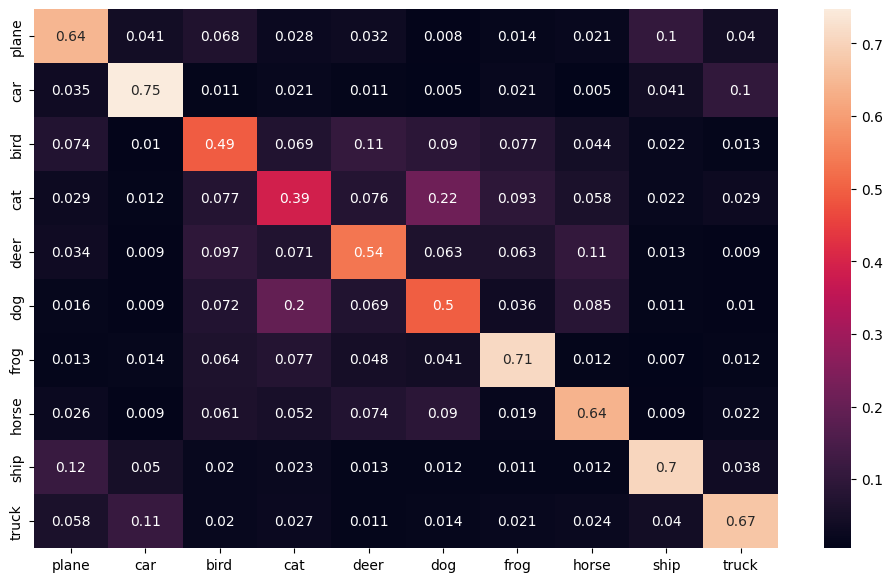

In [13]:
from sklearn.metrics import  confusion_matrix
import pandas as pd
import seaborn as sn

# Test the model
model.eval()
# Accumulate the number of total and correct predictions, ground truths and predictions for the confusion matrix
correct = 0
total = 0
predictions_conf = []
ground_truths_conf = []
with torch.no_grad():
    for data in dl_test_cifar10:
        images, targets = data
        # Collect the ground truths
        ground_truths_conf.extend(targets.detach().cpu().numpy())
        images, targets = images.to(device), targets.to(device)
        # Calculate outputs by running images through the network
        logits = model(images)
        # The class with the highest energy is what we choose as prediction
        _, predicted = torch.max(logits.data, 1)
        # Collect the predictions
        predictions_conf.extend(predicted.detach().cpu().numpy())
        # Update the number of all the targets and correct predictions
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Test accuracy of the network: {100 * correct / total} %')

# Build and print confusion matrix
cf_matrix = confusion_matrix(ground_truths_conf, predictions_conf)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

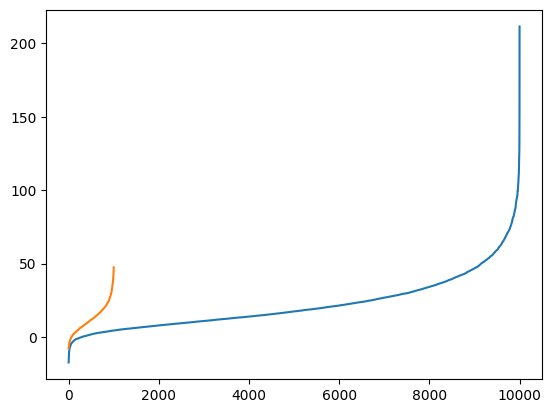

In [28]:
# praticamente è la stessa cosa sotto ma lui l'ha rifatto a lezione, vedere come incorporare tutto
def max_logit(logit):
    return  logit.max(dim=1)[0]

def max_softmax(logit, T):
    s = F.softmax(logit/T, 1)
    s = s.max(1)[0]
    return s
    

# compute scores
def compute_scores(model, dl, score_fun):
    scores = []
    for data in dl:
        images, targets = data
        images, targets = images.to(device), targets.to(device)
        logit = model (images)
        s = score_fun(logit)
        scores.append(s)

    scores_t = torch.cat(scores)
    return scores_t

scores_test_cif10 = compute_scores(model, dl_test_cifar10, max_logit)
scores_fake = compute_scores(model, dl_fake, max_logit)

plt.plot(sorted(scores_test_cif10.detach().cpu()))
plt.plot(sorted(scores_fake.detach().cpu()))


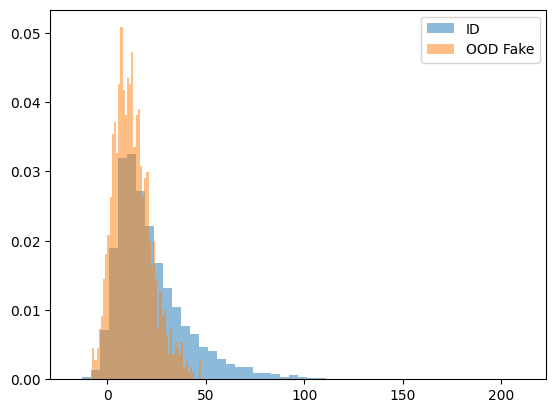

In [29]:
_ = plt.hist(scores_test_cif10.detach().cpu(), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(scores_fake.detach().cpu(), 50, density=True, alpha=0.5, label='OOD Fake')
plt.legend()

In [8]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

In [9]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test_cifar10)
logits_OOD_Fake = collect_logits(model, dl_fake)
logits_OOD_Cifar100 = collect_logits(model, dl_test100)

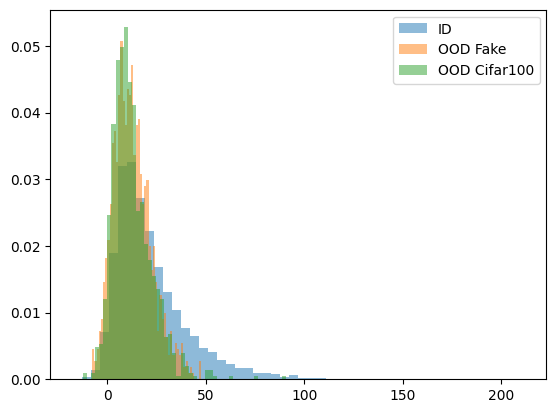

In [10]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD_Fake.max(1), 50, density=True, alpha=0.5, label='OOD Fake')
_ = plt.hist(logits_OOD_Cifar100.max(1), 50, density=True, alpha=0.5, label='OOD Cifar100')
plt.legend()

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


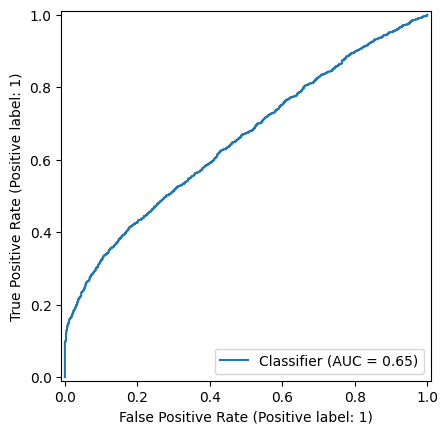

In [30]:
from sklearn import metrics

ypred = torch.cat((scores_test_cif10, scores_fake))
y_test = torch.ones_like(scores_test_cif10)
y_fake = torch.zeros_like(scores_fake)
y_true = torch.cat((y_test, y_fake))

# ??? non ho copiato bene
metrics.RocCurveDisplay.from_predictions(y_true.detach().cpu(), ypred.detach().cpu())

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [4]:
# Your code here.
# prendere modello, forward, prendere il gradiente (usare require grad) rispetto alla x e gli fai il segno.
# sommare segno a immagine scalandolo per un epsilon


### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [ ]:
# Your code here.

# aggiungere esempi adversarial durante il training, es: se batch da 64 concatenare altre 64 esempi adversarial con stesso label, "tipo come abbiamo fatto per le GAN"

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.
